## Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.image as mpimg

In [ ]:
%%capture
pip install pytorch-lightning

In [ ]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback

In [ ]:
!git clone 'https://github.com/Horea94/Fruit-Images-Dataset.git'

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 29.40 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Checking out files: 100% (90503/90503), done.


## Prepare Dataset

In [ ]:
dir = '/content/Fruit-Images-Dataset/Training'
i=0
headerlist = ['image_name', 'target']
with open('./fruit_train.csv', 'w') as f: # every time session started, github cloned
  f.write(headerlist[0] + ',' + headerlist[1] + '\n') # folder structure is loaded in different ways ???
  for folder in os.listdir(dir):                      # just create temporary file of these
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(folder + '/' + image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


In [ ]:
dir = '/content/Fruit-Images-Dataset/Test'
i=0
headerlist = ['image_name', 'target']
with open('./fruit_test.csv', 'w') as f:
  f.write(headerlist[0] + ',' + headerlist[1] + '\n')
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(folder + '/' + image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


In [ ]:
class FruitsDataset(Dataset):

  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_name = self.annotations.iloc[index, 0]  # Quince/r_305_100.jpg
    path = os.path.join(self.root_dir, img_name)
    img = Image.open(path).convert('RGB')
    label = torch.tensor(self.annotations.iloc[index, 1])

    if self.transform:
      img = self.transform(img)

    return (img, label)

In [ ]:
dir = '/content/Fruit-Images-Dataset/Training'
fruit_names = {}
i=0
for folder in os.listdir(dir):
  fruit_names[i] = folder
  i+=1
print(fruit_names)

{0: 'Nectarine', 1: 'Avocado', 2: 'Strawberry Wedge', 3: 'Apple Granny Smith', 4: 'Pear Forelle', 5: 'Clementine', 6: 'Banana', 7: 'Tomato 3', 8: 'Pear Kaiser', 9: 'Plum 2', 10: 'Tomato 1', 11: 'Pepper Red', 12: 'Apple Pink Lady', 13: 'Potato White', 14: 'Tomato Heart', 15: 'Maracuja', 16: 'Cherry Wax Red', 17: 'Apple Red Delicious', 18: 'Apple Red 3', 19: 'Plum 3', 20: 'Pomelo Sweetie', 21: 'Corn', 22: 'Pear 2', 23: 'Banana Red', 24: 'Corn Husk', 25: 'Tomato 4', 26: 'Lemon Meyer', 27: 'Mulberry', 28: 'Apple Golden 2', 29: 'Apple Golden 3', 30: 'Mango Red', 31: 'Chestnut', 32: 'Pitahaya Red', 33: 'Cucumber Ripe', 34: 'Pear Stone', 35: 'Potato Sweet', 36: 'Blueberry', 37: 'Cauliflower', 38: 'Nut Forest', 39: 'Dates', 40: 'Grape Blue', 41: 'Tomato Maroon', 42: 'Apple Red 1', 43: 'Mangostan', 44: 'Tomato Yellow', 45: 'Pepino', 46: 'Peach', 47: 'Lychee', 48: 'Kiwi', 49: 'Cantaloupe 1', 50: 'Grapefruit White', 51: 'Walnut', 52: 'Limes', 53: 'Nectarine Flat', 54: 'Apricot', 55: 'Pear Abate',

In [ ]:
mean = torch.tensor([0.6840, 0.5786, 0.5037])
std = torch.tensor([0.3035, 0.3600, 0.3914])

In [ ]:
train_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.RandomPerspective(distortion_scale=0.5),
                                  transforms.RandomAffine(degrees=(30, 70)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

val_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

test_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

pred_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.ToTensor()
])

In [ ]:
dir = '/content/Fruit-Images-Dataset/Training'
train_csv = './fruit_train.csv'
train_dataset = FruitsDataset(csv_file=train_csv, root_dir=dir, transform=train_trans)
print(len(train_dataset))

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, lengths=[train_size, val_size])
print(len(train_dataset), len(val_dataset))

dir = '/content/Fruit-Images-Dataset/Test'
test_csv = './fruit_test.csv'
test_dataset = FruitsDataset(csv_file=test_csv, root_dir=dir, transform=test_trans)
print(len(test_dataset))

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

67692
54153 13539
22688


## Prepare model

In [ ]:
model = torchvision.models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
num_classes = 131
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
class FruitsClassification(pl.LightningModule):

  def __init__(self, model, learning_rate=0.01):
    super(FruitsClassification, self).__init__()
    self.model = model
    self.criterion = nn.CrossEntropyLoss()

    self.lr = learning_rate

    self.train_losses = list()
    self.train_accs = list()
    self.train_loss = list()
    self.train_acc = list()
    self.val_loss = list()
    self.val_acc = list()
    self.best_acc = 0.0

    self.save_hyperparameters(ignore=['model'])

  def training_step(self, batch, batch_idx):
    loss, acc = self._shared_eval_step(batch, batch_idx)
    self.train_losses.append(loss.item())
    self.train_accs.append(acc.item())
    metrics = {'loss': loss, 'train_acc': acc}
    pbar = {'train_loss': loss, 'train_acc': acc}
    self.log_dict(pbar, on_epoch=True, on_step=False, prog_bar=True, logger=True)
    return metrics

  def validation_step(self, batch, batch_idx):
    loss, acc = self._shared_eval_step(batch, batch_idx)
    metrics = {'val_loss': loss, 'val_acc': acc}
    self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True, logger=True)
    return metrics

  def validation_epoch_end(self, outputs):
    avg_val_loss = torch.tensor([x['val_loss'].item() for x in outputs]).mean()
    avg_val_acc = torch.tensor([x['val_acc'].item() for x in outputs]).mean()
    print(f'Epoch {self.current_epoch + 1} ' \
          f'Val Loss: {avg_val_loss:.3f}, Val Acc: {avg_val_acc:.2f}')
    self.val_loss.append(avg_val_loss.item())
    self.val_acc.append(avg_val_acc.item())
    if avg_val_acc.item() > self.best_acc:
      self.best_acc = avg_val_acc.item()

  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.model(x)
    _, index = torch.max(logits, 1)
    loss = self.criterion(logits, y)
    acc = accuracy(logits, y)
    metrics = {'test_loss': loss, 'test_acc': acc}
    self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True, logger=True)
    metrics['index'] = index
    return metrics

  def test_step_end(self, outputs):
    return outputs['index']

  def predict_step(self, batch, batch_idx, dataloader_idx=0):
    x, y = batch
    logits = self.model(x)
    _, index = torch.max(logits, 1)
    return index

  def _shared_eval_step(self, batch, batch_idx):
    x, y = batch
    logits = self.model(x)
    loss = self.criterion(logits, y)
    acc = accuracy(logits, y)
    return loss, acc

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
mymodel = FruitsClassification(model, learning_rate=0.01)

0.01

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='/content/drive/MyDrive/outputs',
    filename='sample-fruits-{epoch}-{val_acc:.2f}',
    save_top_k=1,
    mode='max'
)

## Writing Callbacks

In [ ]:
class MyPrintingCallback(Callback):

  def __init__(self, cb_dir, test_dir):
    super().__init__()
    self.epoch_start = None
    self.epoch_end = None
    self.start = None
    self.end = None
    self.path = cb_dir
    self.path2 = test_dir
    self.targets = np.array(list())
    self.preds = np.array(list())
    self.num_samples = 0
    self.running_corrects = 0
    self.num_classes= 131
    self.n_correct_class = [0 for i in range(self.num_classes)]
    self.n_class_samples = [0 for i in range(self.num_classes)]
    self.absent_class = list()
    self.accdict = {}
    self.corrects = list()

  def on_fit_start(self, trainer, pl_module):
    print('===> Sanity check...')

  def on_train_start(self, trainer, pl_module):
    self.start = time.time()

  def on_train_epoch_start(self, trainer, pl_module):
    print('In training...')
    self.epoch_start = time.time()

  def on_validation_epoch_start(self, trainer, pl_module):
    avg_train_loss = torch.tensor(pl_module.train_losses).mean()
    avg_train_acc = torch.tensor(pl_module.train_accs).mean()
    pl_module.train_loss.append(avg_train_loss.item())
    pl_module.train_acc.append(avg_train_acc.item())
    print(f'Epoch {pl_module.current_epoch + 1} ' \
          f'Train Loss: {avg_train_loss:.3f}, Train Acc: {avg_train_acc:.2f}')

  def on_train_epoch_end(self, trainer, pl_module):
    self.epoch_end = time.time()
    duration = self.epoch_start - self.epoch_end
    print(f'Time spent for Epoch {pl_module.current_epoch + 1} -----> {int(duration // 60)}m {int(duration % 60)}s')
    print("")

  def on_train_end(self, trainer, pl_module):
    self.end = time.time()
    duration = self.start - self.end
    print(f'Training completes in -----> {int(duration // 60)}m {int(duration % 60)}s')
    print(f'Best Validation Accuracy is {pl_module.best_acc:.3f}')
    torch.save({
            'train_loss': pl_module.train_loss,
            'train_acc': pl_module.train_acc,
            'val_loss': pl_module.val_loss,
            'val_acc': pl_module.val_acc,
            'best_acc':pl_module.best_acc,
            'targets': self.targets,
            'preds': self.preds,
            'absent_class': self.absent_class,
            'accdict': self.accdict,
            'corrects': self.corrects
            }, self.path)
    
  def on_test_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx):
    x, y = batch
    self.targets = np.concatenate((self.targets, y.cpu().numpy()), axis=None)

  def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
    self.preds = np.concatenate((self.preds, outputs.cpu().numpy()), axis=None)
    self.num_samples += outputs.shape[0]
    x, y = batch
    self.running_corrects += torch.sum(outputs == y)
    labels = y.cpu().numpy()
    outputs_ = outputs.cpu().numpy()
    for i in range(labels.shape[0]):
      label = labels[i]
      index_i = outputs_[i]

      if label == index_i:
        self.n_correct_class[label] += 1
      self.n_class_samples[label] += 1

  def on_test_epoch_end(self, trainer, pl_module):
    print(f'Got {self.running_corrects.item()}/{self.num_samples} correct samples.')
    for i in range(self.num_classes):
      if self.n_class_samples[i] != 0:
        acc_ = self.n_correct_class[i] / self.n_class_samples[i]
        self.accdict[i] = [acc_]
        temp = {'class': i, 'n_correct_class': self.n_correct_class[i], 'n_class_samples': self.n_class_samples[i]}
        self.corrects.append(temp)
      else:
        self.absent_class.append(i)
    torch.save({
            'targets': self.targets,
            'preds': self.preds,
            'absent_class': self.absent_class,
            'accdict': self.accdict,
            'corrects': self.corrects
            }, self.path2)

## Training

In [ ]:
save_dir = "/content/drive/MyDrive/outputs"
cb_dir = '/content/drive/MyDrive/callbacks/plot.pth'
cb = MyPrintingCallback(cb_dir=cb_dir)
trainer = pl.Trainer(fast_dev_run=False, log_every_n_steps=1, max_epochs=1, default_root_dir=save_dir,
                     callbacks=[checkpoint_callback, cb], gpus=1)

trainer.fit(mymodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/drive/MyDrive/outputs/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GoogLeNet        | 5.7 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
134 K     Trainable params
5.6 M     Non-trainable params
5.7 M     Total params
22.937    Total estimated model params size (MB)


===> Sanity check...


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1 Train Loss: 4.882, Train Acc: 0.02


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1 Val Loss: 6.760, Val Acc: 0.00


Training: 0it [00:00, ?it/s]

In training...


Validation: 0it [00:00, ?it/s]

Epoch 1 Train Loss: 0.851, Train Acc: 0.79
Epoch 1 Val Loss: 0.270, Val Acc: 0.91
Time spent for Epoch 1 -----> -6m 2s

Training completes in -----> -6m 1s
Best Validation Accuracy is 0.914


## Resumed training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    every_n_train_steps=0,
    every_n_epochs=1,
    train_time_interval=None,
    save_on_train_epoch_end=True,
    save_top_k=1,
    dirpath='/content/drive/MyDrive/outputs', # kept this folder as in previous train
    filename='resumed-sample-fruits-{epoch}-{val_acc:.2f}' # rename this so wont cause error file exists
                                                          # file will be updated.
)
path = '/content/drive/MyDrive/outputs/sample-fruits-epoch=0-val_acc=0.91.ckpt'
cb_dir = '/content/drive/MyDrive/callbacks/plot2.pth'
cb = MyPrintingCallback(cb_dir=cb_dir)
save_dir="/content/drive/MyDrive/outputs2"
trainer = pl.Trainer(fast_dev_run=False, max_epochs=6, log_every_n_steps=1,
                     callbacks=[checkpoint_callback, cb],
                     default_root_dir=save_dir, gpus=1)
trainer.fit(mymodel, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path=path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/drive/MyDrive/outputs2/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /content/drive/MyDrive/outputs/sample-fruits-epoch=0-val_acc=0.91.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GoogLeNet        | 5.7 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
134 K     Trainable params
5.6 M     Non-trainable params
5.7 M     Total params
22.937    Total estimated model params size (MB)
Restored all st

===> Sanity check...


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1 Train Loss: 0.851, Train Acc: 0.79


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1 Val Loss: 0.221, Val Acc: 0.93


Training: 424it [00:00, ?it/s]

In training...


Validation: 0it [00:00, ?it/s]

Epoch 2 Train Loss: 0.610, Train Acc: 0.84
Epoch 2 Val Loss: 0.240, Val Acc: 0.92
Time spent for Epoch 2 -----> -6m 2s

In training...


Validation: 0it [00:00, ?it/s]

Epoch 3 Train Loss: 0.529, Train Acc: 0.86
Epoch 3 Val Loss: 0.225, Val Acc: 0.93
Time spent for Epoch 3 -----> -6m 4s

In training...


Validation: 0it [00:00, ?it/s]

Epoch 4 Train Loss: 0.482, Train Acc: 0.87
Epoch 4 Val Loss: 0.206, Val Acc: 0.94
Time spent for Epoch 4 -----> -6m 8s

In training...


Validation: 0it [00:00, ?it/s]

Epoch 5 Train Loss: 0.457, Train Acc: 0.88
Epoch 5 Val Loss: 0.195, Val Acc: 0.94
Time spent for Epoch 5 -----> -6m 10s

In training...


Validation: 0it [00:00, ?it/s]

Epoch 6 Train Loss: 0.442, Train Acc: 0.88
Epoch 6 Val Loss: 0.159, Val Acc: 0.95
Time spent for Epoch 6 -----> -6m 10s

Training completes in -----> -30m 36s
Best Validation Accuracy is 0.954


## Visualize loss and acc

In [ ]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(range(1, num_epochs+1), np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(range(1, num_epochs+1), np.array(loss_val), '-o', label='val', linewidth=2)
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_val), '-o', label='val', linewidth=2)
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

### Concatenate plot data from a previous train

In [ ]:
path = '/content/drive/MyDrive/callbacks/plot.pth'
plotdata = torch.load(path)
train_loss1 = plotdata['train_loss']
train_acc1 = plotdata['train_acc']
val_loss1 = plotdata['val_loss']
val_acc1 = plotdata['val_acc']
print(train_loss1)
print(train_acc1)
print(val_loss1)
print(val_acc1)
# max_epochs=1, there should be 1 values in each set
# 2 extra come from sanity check at the beginning

[4.8817138671875, 4.8817138671875, 0.8507924675941467]
[0.015625, 0.015625, 0.7860763669013977]
[6.903825283050537, 6.759788513183594, 0.27012866735458374]
[0.0, 0.00390625, 0.9141629934310913]


In [ ]:
train_loss1 = plotdata['train_loss'][2:]
train_acc1 = plotdata['train_acc'][2:]
val_loss1 = plotdata['val_loss'][2:]
val_acc1 = plotdata['val_acc'][2:]

In [ ]:
mymodel.train_loss # the first 2 values didn't seem to be in line with the other values

[4.8817138671875,
 4.8817138671875,
 0.8507924675941467,
 0.8507924675941467,
 0.6097231507301331,
 0.5290231108665466,
 0.4819168448448181,
 0.45743852853775024,
 0.4421851933002472]

In [ ]:
print(len(mymodel.train_loss))

9


In [ ]:
mymodel.train_acc

[0.015625,
 0.015625,
 0.7860763669013977,
 0.7860763669013977,
 0.8368107080459595,
 0.8555188179016113,
 0.8676866888999939,
 0.8753028512001038,
 0.8807520270347595]

In [ ]:
mymodel.val_loss

[6.903825283050537,
 6.759788513183594,
 0.27012866735458374,
 0.22106242179870605,
 0.23982669413089752,
 0.22481919825077057,
 0.20626023411750793,
 0.19489362835884094,
 0.1588781177997589]

In [ ]:
mymodel.val_acc

[0.0,
 0.00390625,
 0.9141629934310913,
 0.93359375,
 0.9225561618804932,
 0.9304512739181519,
 0.9394341111183167,
 0.9432450532913208,
 0.9544605612754822]

In [ ]:
train_loss2 = mymodel.train_loss[2:]
train_acc2 = mymodel.train_acc[2:]
val_loss2 = mymodel.val_loss[2:]
val_acc2 = mymodel.val_acc[2:]

In [ ]:
train_loss = train_loss1 + train_loss2
train_acc = train_acc1 + train_acc2
val_loss = val_loss1 + val_loss2
val_acc = val_acc1 + val_acc2

### Loss and acc graph

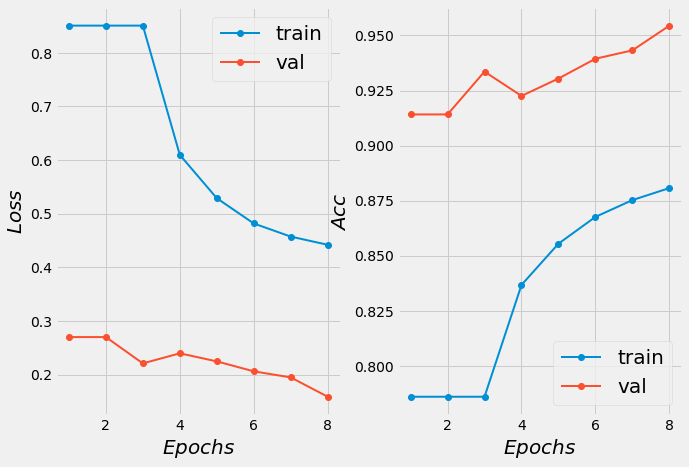

In [ ]:
num_epochs = 8
visualize_cost(train_loss, train_acc, val_loss, val_acc)

## Test

In [ ]:
trainer.test(mymodel, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Got 13936/22688 correct samples.
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6142454147338867
        test_loss            3.096449613571167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6142454147338867, 'test_loss': 3.096449613571167}]

### Checking targets and preds loaded in the correct way

In [ ]:
cb.preds

array([17.,  0.,  0., ...,  7.,  7., 19.])

In [ ]:
cb.targets

array([  0.,   0.,   0., ..., 130., 130., 130.])

In [ ]:
len(cb.targets)

22688

In [ ]:
len(cb.preds)

22688

## Visualize model outputs with labels: correct(green), incorrect(red).

In [ ]:
def visualize_model(labels_map, num_rows, num_cols, num_images, dataset, predicted_class):

  plt.figure(figsize=(10, 10))

  for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[index]
    image = image.numpy().transpose(1,2,0)
    image = image * np.array(std) + np.array(mean)
    plt.imshow(image)
    plt.axis('off')
    if label.item() == predicted_class[index]:
      check = 'green'
    else: check = 'red'
    plt.title(f'Pred: {labels_map[predicted_class[index]]}', color='white',
              backgroundcolor=check, fontsize=15)
    i+=1
    if i==num_images:
      break

  plt.show()

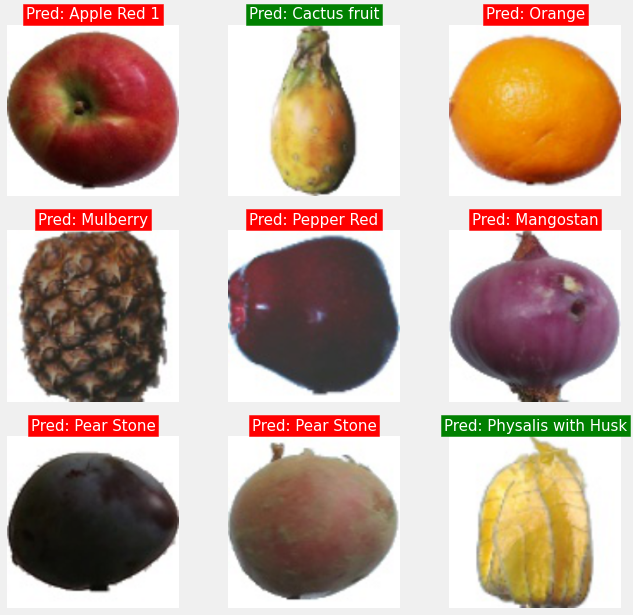

In [ ]:
visualize_model(fruit_names, 3, 3, 9, test_dataset, cb.preds)

## Check accuracy

In [ ]:
df = pd.DataFrame.from_dict(cb.accdict)
df

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.726027,0.178862,0.412281,0.228916,0.920732,0.710843,0.073171,0.810976,0.96988,0.439759,...,1.0,0.109589,0.819277,0.973856,0.231707,0.963855,0.944444,0.451807,1.0,0.0


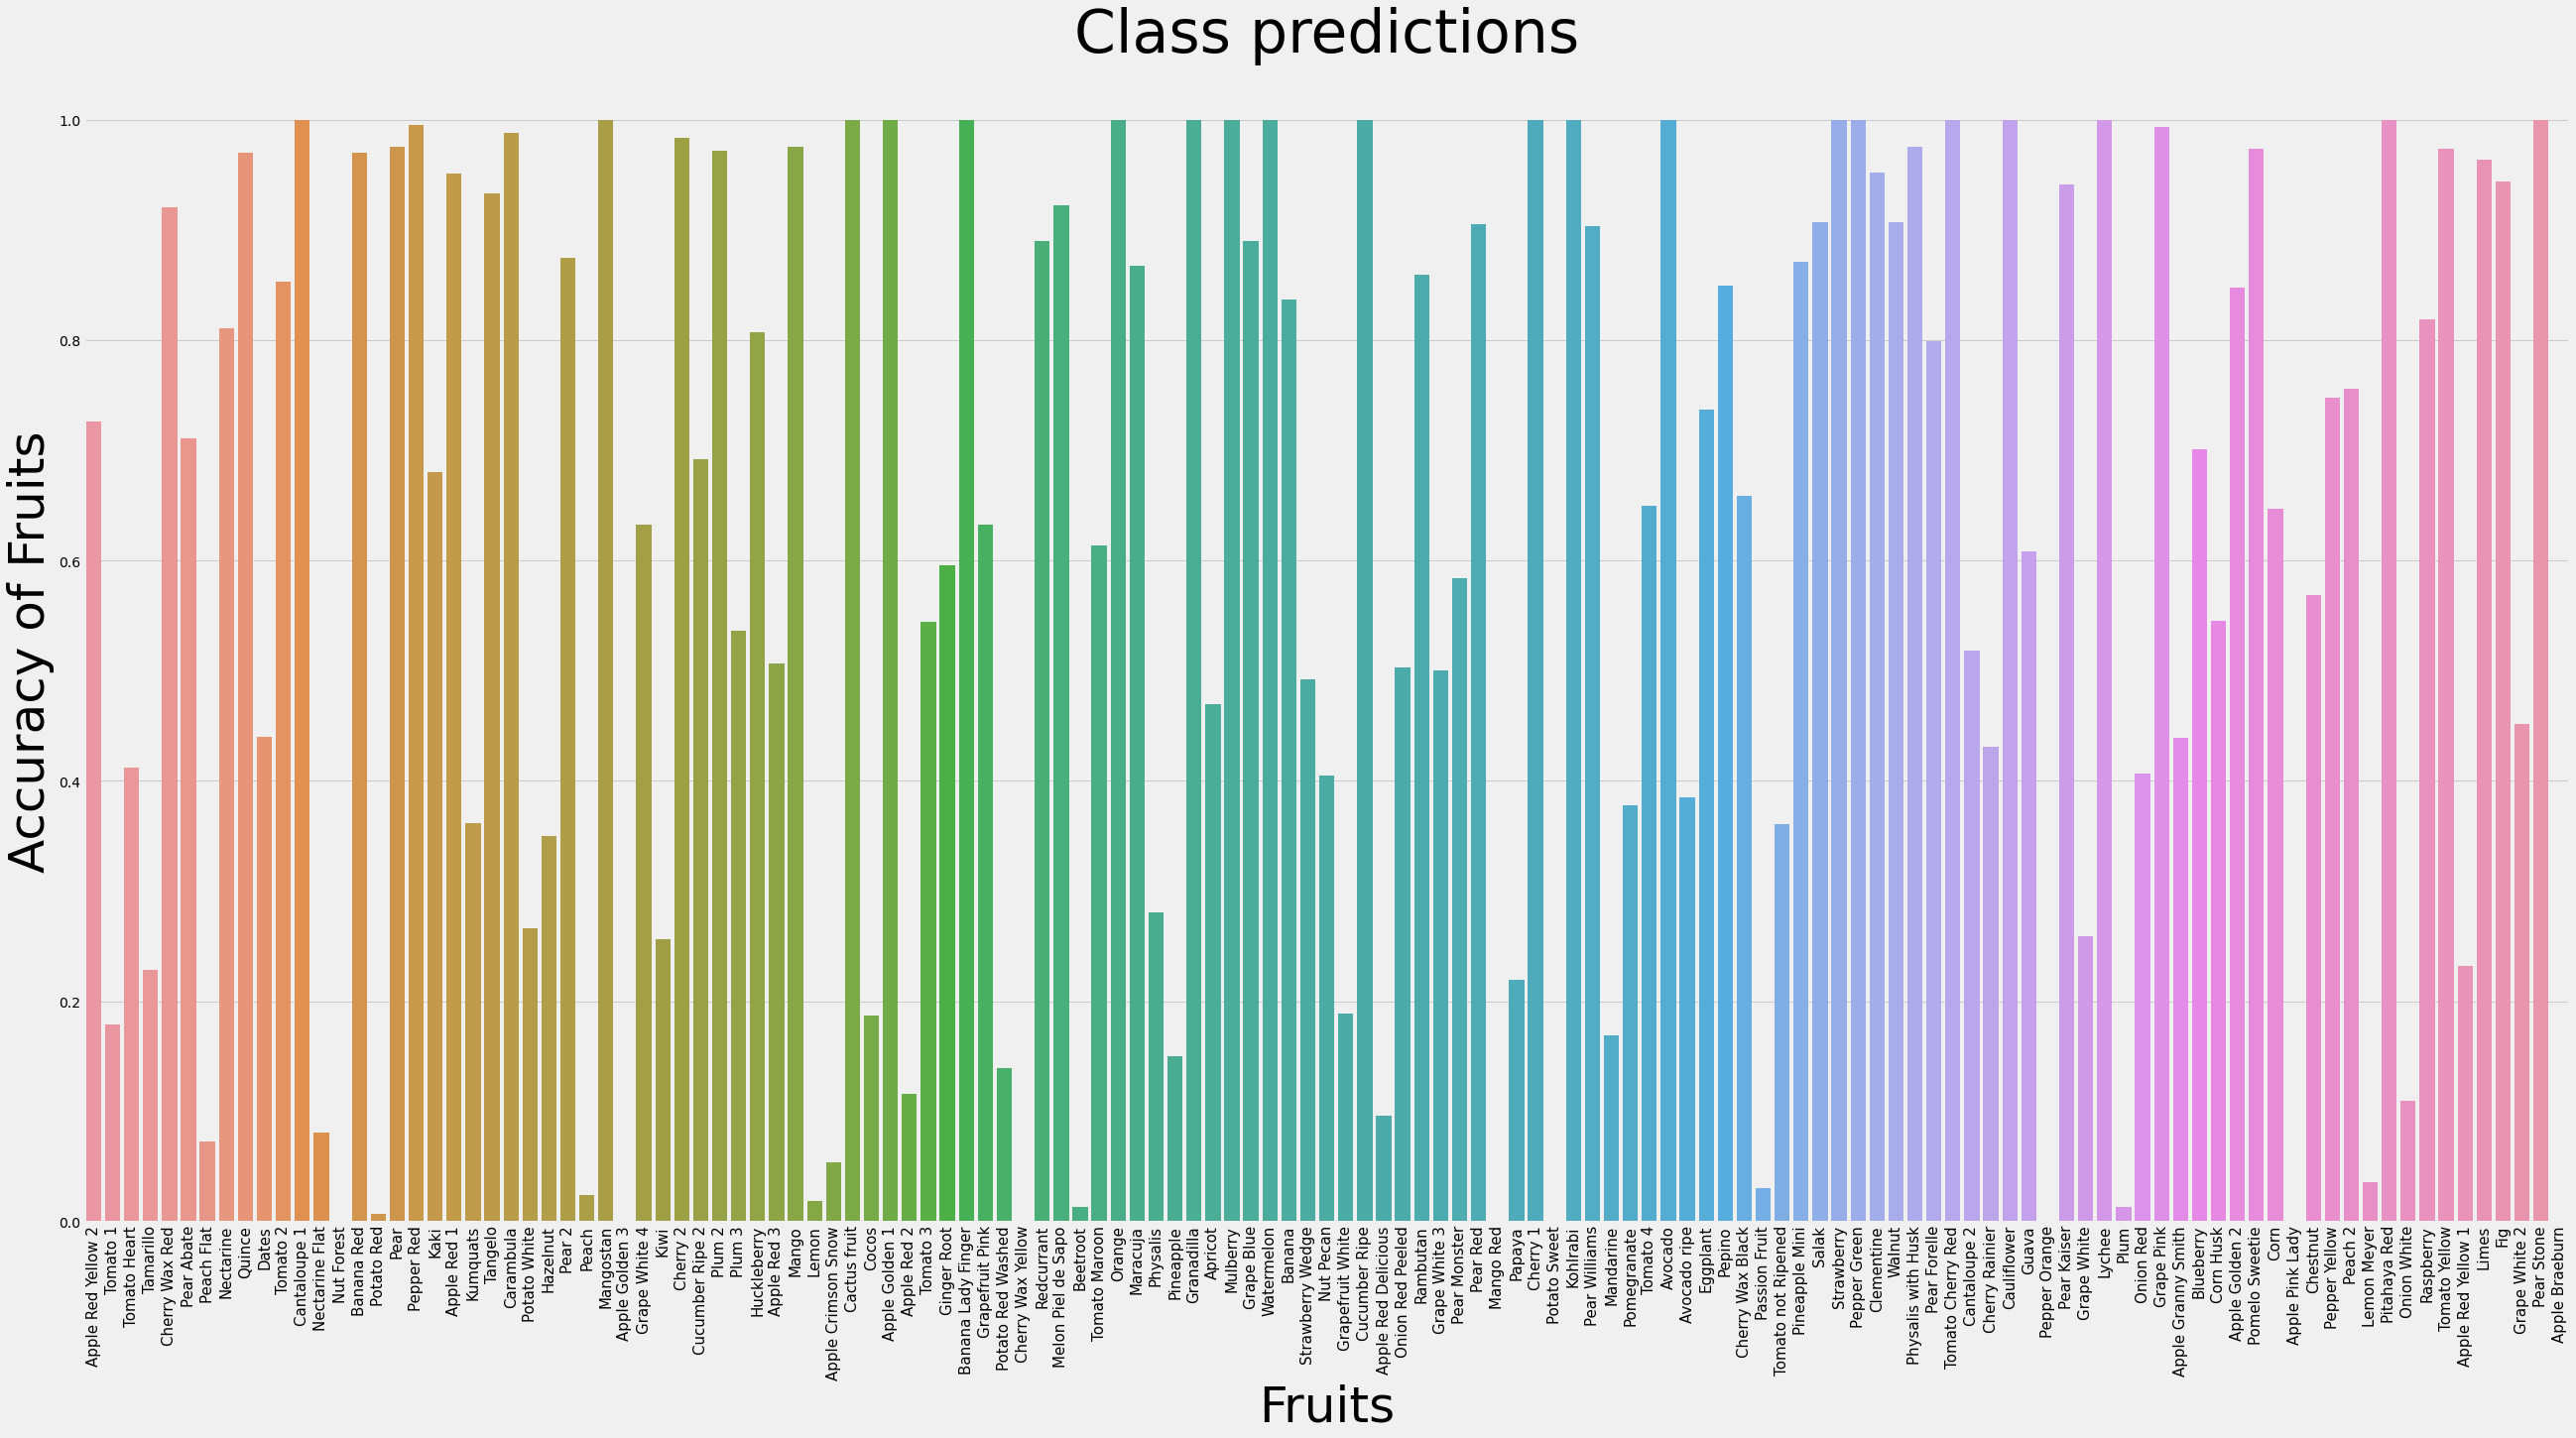

In [ ]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
import seaborn as sn

sn.barplot(data=df)

index = np.arange(df.shape[1])
classes = list(fruit_names.values())

plt.xlabel('Fruits', fontsize=50)
plt.ylabel('Accuracy of Fruits ', fontsize=50)
plt.xticks(index, classes, fontsize=15, rotation=90)
plt.title('Class predictions', fontsize=60)
plt.show()

## Predict

In [ ]:
dir = '/content/drive/MyDrive/fruits'
with open('./fruits_pred.csv', 'w') as f:
  f.write('image_name' + '\n') # otherwise, your dataset would be missed one sample!
  for image in os.listdir(dir):
    image_path = os.path.join(dir, image)
    f.write(image_path + '\n')
print('Done.')

Done.


In [ ]:
class PredictDataset(Dataset):

  def __init__(self, csv_file, transform):
    self.annotations = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
      return len(self.annotations)

  def __getitem__(self, index):

    image_path = self.annotations.iloc[index, 0]
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return (image, index)

In [ ]:
csv_file = '/content/fruits_pred.csv'
predict_dataset = PredictDataset(csv_file, pred_trans)

In [ ]:
def show(dataset, labels_map={}, num_rows=0, num_cols=0, num_images=0, mean=[], std=[], 
         transform=False, colormap='gray', color='gray', consecutive='no',
         batch_size=0, clip='no', single='no', predictions=[]):

  plt.figure(figsize=(10, 10))
  extract= predictions[0].numpy()

  if consecutive == 'yes':
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    images, _ = next(iter(loader))
    images = torchvision.utils.make_grid(images)
    images = images.numpy().transpose(1,2,0)
    if clip == 'yes':
      images = np.clip(images, 0, 1)

    # if color != 'gray':
      # if transform == False:
      #     images = images*np.array(std) + np.array(mean)

    plt.imshow(images)

  else:

    if single == 'yes':
      num_rows = num_cols = 1
    else:
      num_rows = num_rows
      num_cols = num_cols

    count=0
    for i in range(num_rows*num_cols):
      image, _ = dataset[i]
      if single!= 'yes':
        plt.subplot(num_rows, num_cols, i+1)

      if color == 'gray':
        image = image.squeeze()
        
        if colormap == 'gray':
          plt.imshow(image, cmap='gray')
        else:
          plt.imshow(image, cmap= colormap)

      else:

        image = image.numpy().transpose(1,2,0)
        if clip == 'yes':
          image = np.clip(image, 0, 1)

        # if transform == False:
        #   image = image*np.array(std) + np.array(mean)

        plt.imshow(image)
      
      plt.axis('off')      
      plt.title(labels_map[extract[i]], fontsize=15, color='white',
              backgroundcolor='purple') # if label is tensor, .item()
      count+=1
      if num_images == count:
        break
  # plt.axis('off')

  plt.show()

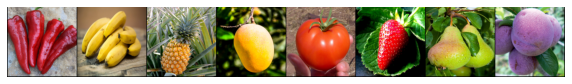

In [ ]:
show(predict_dataset, color='yes', consecutive='yes', batch_size=8)

In [ ]:
predict_loader = DataLoader(predict_dataset, batch_size=8, shuffle=False)

In [ ]:
predictions = trainer.predict(mymodel, dataloaders=predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 424it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
predictions

[tensor([ 96,  96,  64,  62, 118,  64,  64, 129])]

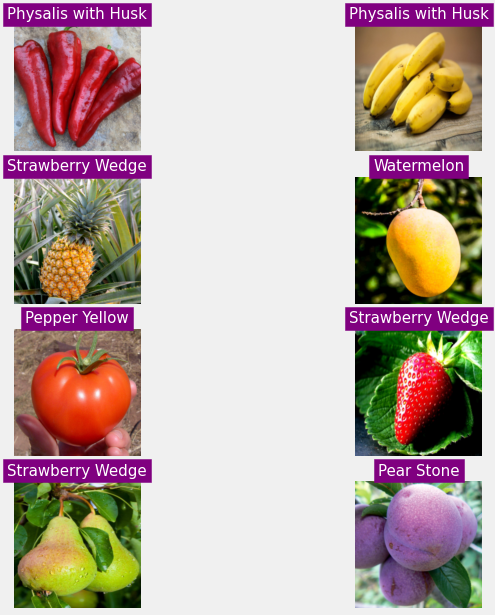

In [ ]:
show(predict_dataset, fruit_names, 4, 2, 8, color='yes', predictions=predictions)

## Check accuracy in num_samples

In [ ]:
print(classification_report(cb.targets, cb.preds))

              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84       219
         1.0       1.00      0.18      0.30       246
         2.0       0.98      0.41      0.58       228
         3.0       1.00      0.23      0.37       166
         4.0       0.87      0.92      0.89       164
         5.0       0.98      0.71      0.82       166
         6.0       0.86      0.07      0.13       164
         7.0       0.20      0.81      0.32       164
         8.0       0.81      0.97      0.88       166
         9.0       1.00      0.44      0.61       166
        10.0       0.66      0.85      0.75       225
        11.0       0.99      1.00      1.00       164
        12.0       0.87      0.08      0.15       160
        13.0       0.00      0.00      0.00       218
        14.0       0.67      0.97      0.79       166
        15.0       1.00      0.01      0.01       150
        16.0       0.34      0.98      0.51       164
        17.0       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cb.corrects

[{'class': 0, 'n_class_samples': 219, 'n_correct_class': 159},
 {'class': 1, 'n_class_samples': 246, 'n_correct_class': 44},
 {'class': 2, 'n_class_samples': 228, 'n_correct_class': 94},
 {'class': 3, 'n_class_samples': 166, 'n_correct_class': 38},
 {'class': 4, 'n_class_samples': 164, 'n_correct_class': 151},
 {'class': 5, 'n_class_samples': 166, 'n_correct_class': 118},
 {'class': 6, 'n_class_samples': 164, 'n_correct_class': 12},
 {'class': 7, 'n_class_samples': 164, 'n_correct_class': 133},
 {'class': 8, 'n_class_samples': 166, 'n_correct_class': 161},
 {'class': 9, 'n_class_samples': 166, 'n_correct_class': 73},
 {'class': 10, 'n_class_samples': 225, 'n_correct_class': 192},
 {'class': 11, 'n_class_samples': 164, 'n_correct_class': 164},
 {'class': 12, 'n_class_samples': 160, 'n_correct_class': 13},
 {'class': 13, 'n_class_samples': 218, 'n_correct_class': 0},
 {'class': 14, 'n_class_samples': 166, 'n_correct_class': 161},
 {'class': 15, 'n_class_samples': 150, 'n_correct_class': 

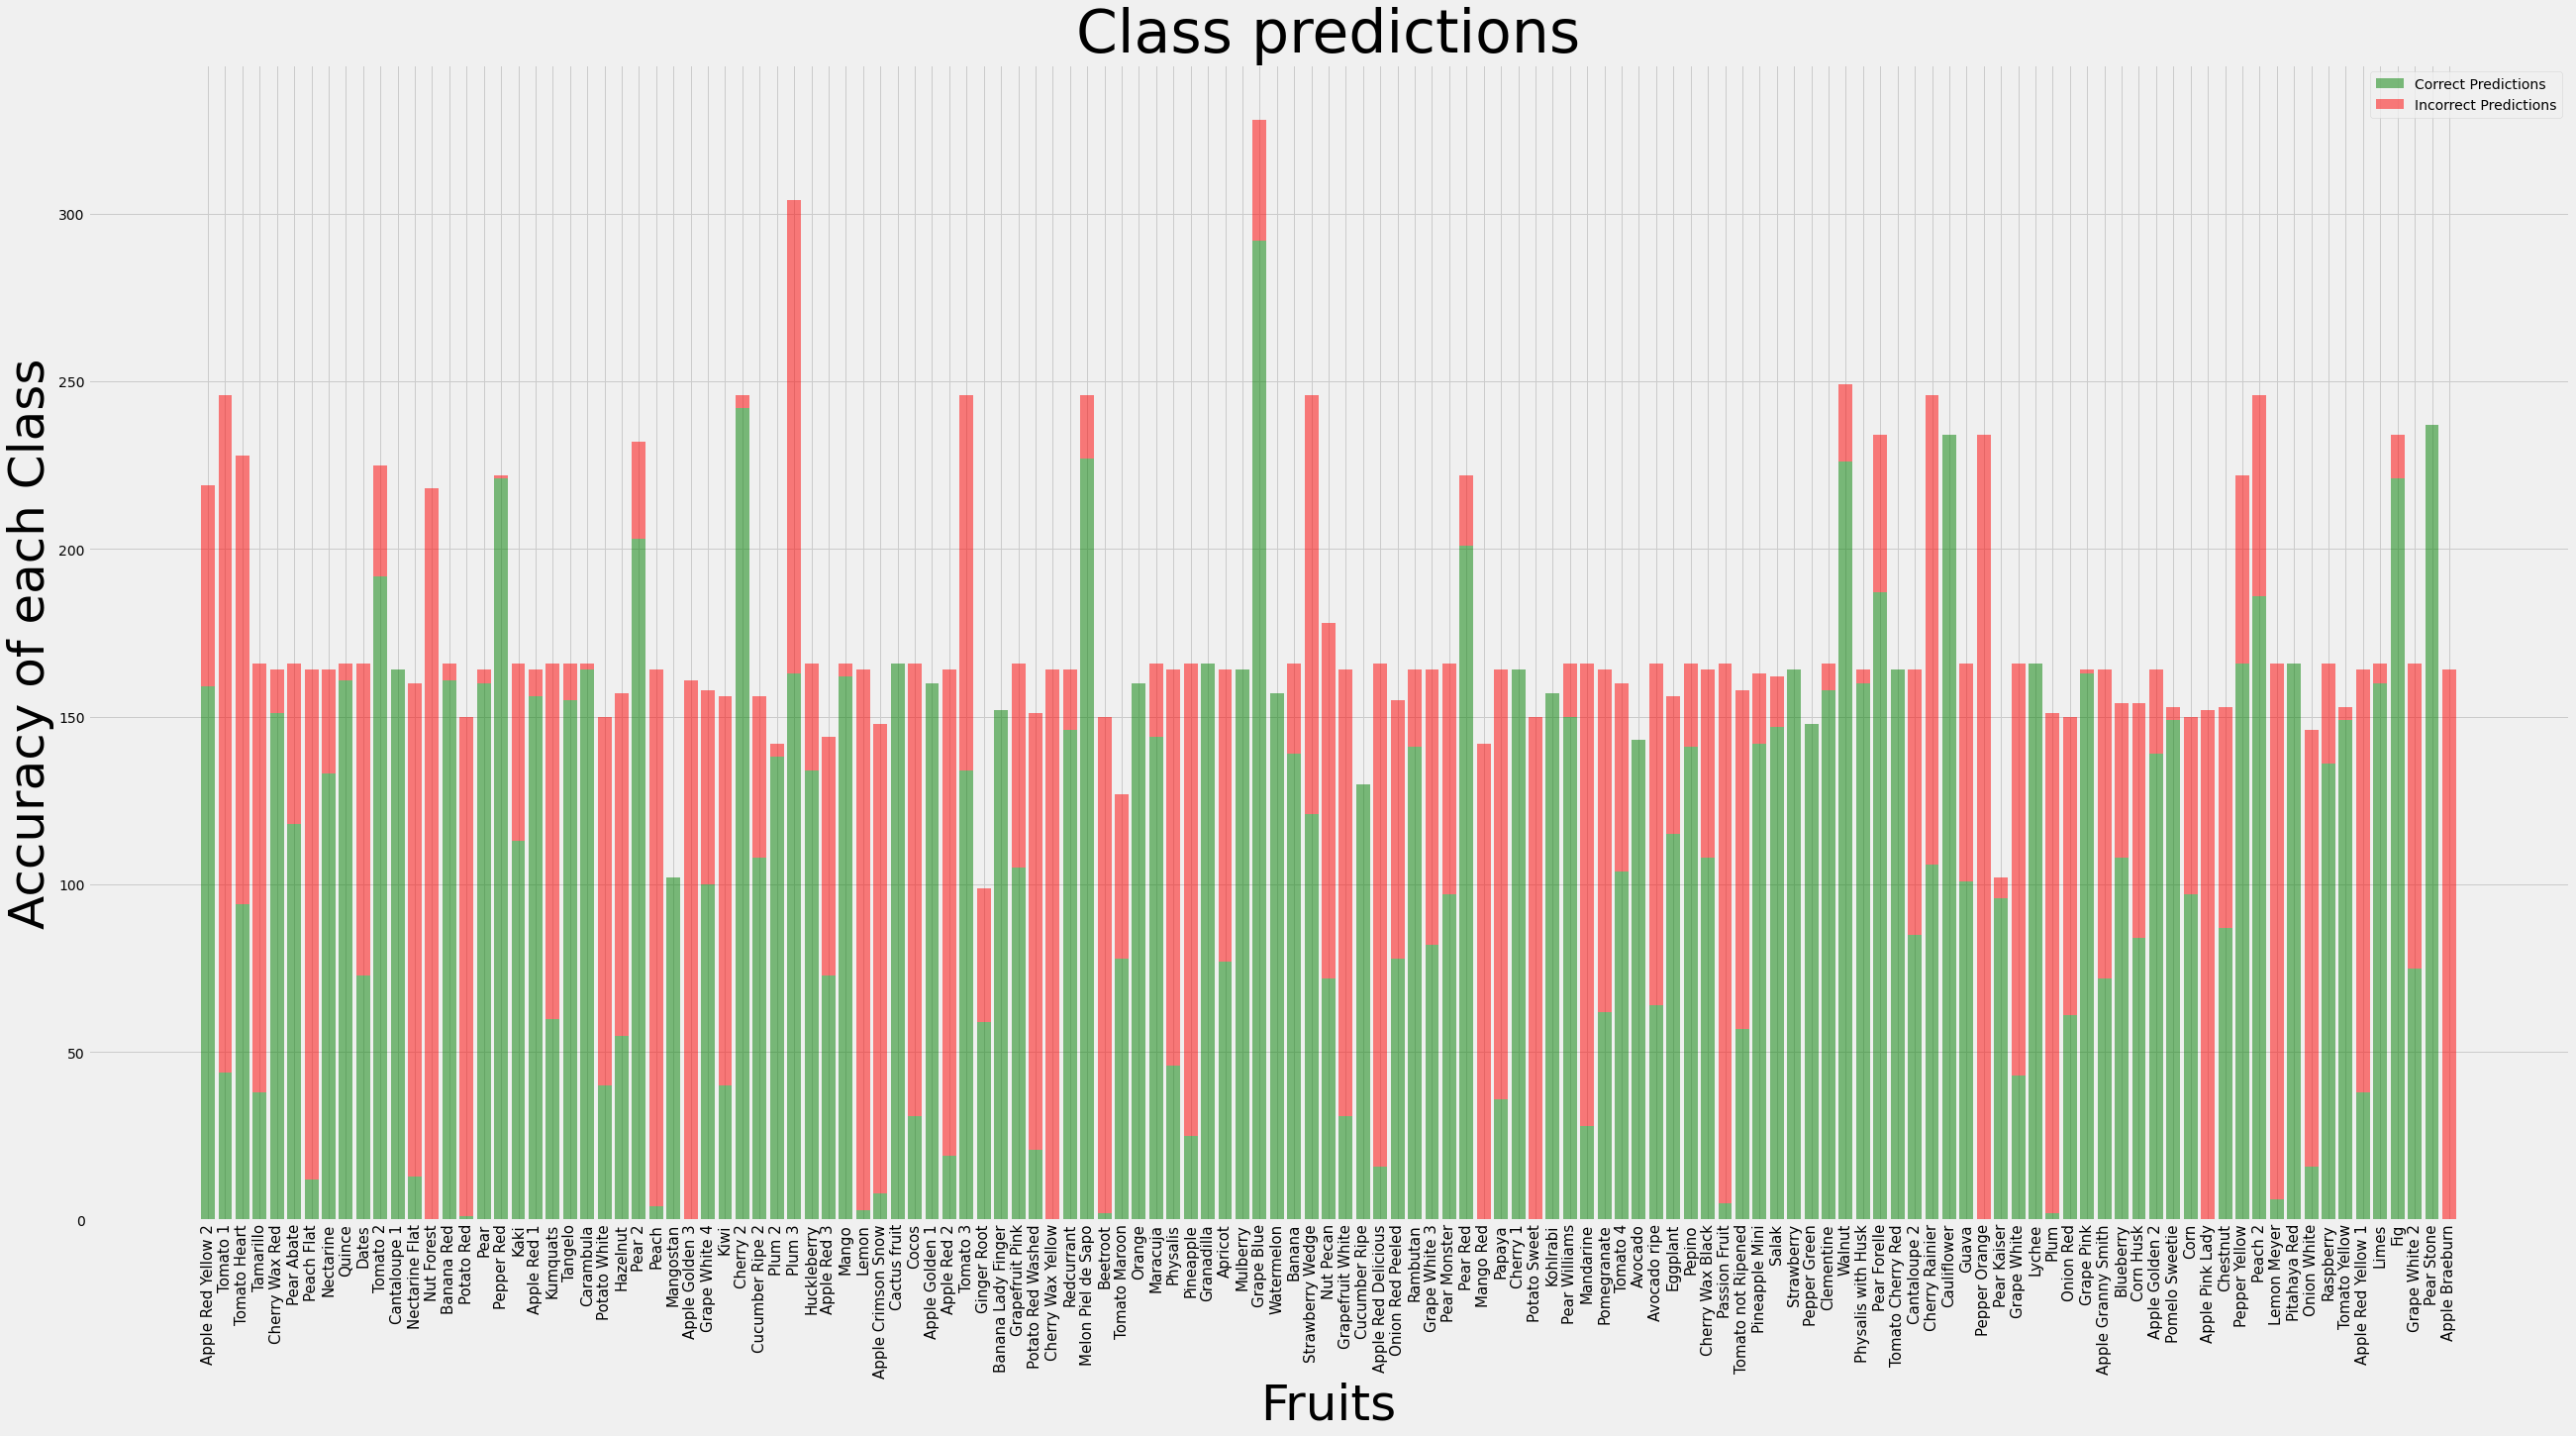

In [ ]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size

X = [fruit_names[x['class']] for x in cb.corrects]
y1 = [x['n_correct_class'] for x in cb.corrects]
y2 = [(x['n_class_samples'] - x['n_correct_class']) for x in cb.corrects]
plt.bar(X, y1, color='green', alpha=0.5)
plt.bar(X, y2, bottom=y1, color='red', alpha=0.5)

index = np.arange(131)
classes = list(fruit_names.values())

plt.xlabel('Fruits', fontsize=50)
plt.ylabel('Accuracy of each Class', fontsize=50)
plt.xticks(index, classes, fontsize=15, rotation=90)
plt.title('Class predictions', fontsize=60)
plt.legend(['Correct Predictions', 'Incorrect Predictions'])
plt.show()